In [1]:
%pylab inline
import numpy as np
import xlrd
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from matplotlib.patches import Polygon
import h5py
import cmocean.cm as cmo
import gsw

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Populating the interactive namespace from numpy and matplotlib


In [2]:
savefig = True
figext = '.pdf'
datadir = '/Users/erik/Desktop/'

degsym = u'\u00B0'

def savefig(fignum, figext=figext, savefig=savefig):
    figname = 'Fig%s%s' % (fignum, figext)
    if savefig:
        plt.savefig(figname)

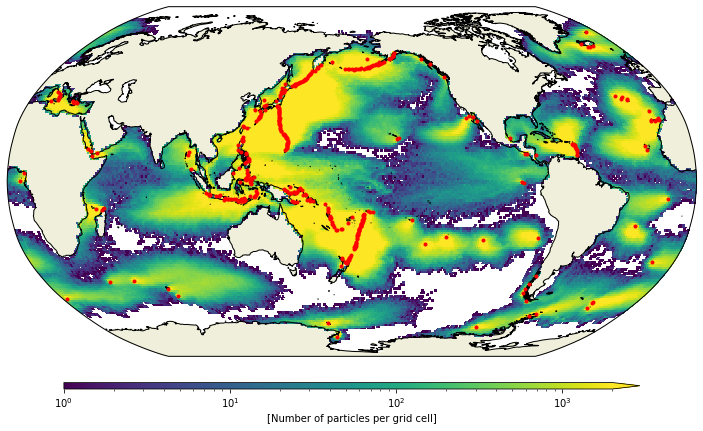

In [3]:
fignum = '03_19'

pumice_sources = xlrd.open_workbook(datadir+'OtherData/Pumice/pumicesources.xlsx').sheet_by_index(0)
slon = pumice_sources.col_values(3)
slat = pumice_sources.col_values(2)

trajs = h5py.File(datadir+'OtherData/Pumice/trajs.mat','r')
lon = np.array(trajs.get('lon'))[0]
lat = np.array(trajs.get('lat'))[0]
starts = np.array(trajs.get('starts'))[0]
ends = np.array(trajs.get('ends'))[0]
startsite = np.array(trajs.get('startsite'))[0]

tlens=180/5-1
for s, e in zip(starts, ends):
    if e-s >= tlens:
        lon[int(s+tlens):int(e)] = np.nan
        lat[int(s+tlens):int(e)] = np.nan
A = np.histogram2d(lon[~np.isnan(lon)], lat[~np.isnan(lat)], [360, 180], range=[[0, 360], [-90, 90]])

projection = cartopy.crs.Robinson(central_longitude=180)
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[7, 1])
ax = fig.add_subplot(gs[0], projection=projection)

ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND)

ax.plot(slon, slat, 'r.', transform=cartopy.crs.PlateCarree())
a = ax.pcolormesh(A[1], A[2], A[0].T, norm=colors.LogNorm(vmin=1, vmax=2000), 
                  transform=cartopy.crs.PlateCarree(), rasterized=True)

cbaxes = fig.add_axes([0.1, 0.09, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[Number of particles per grid cell]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

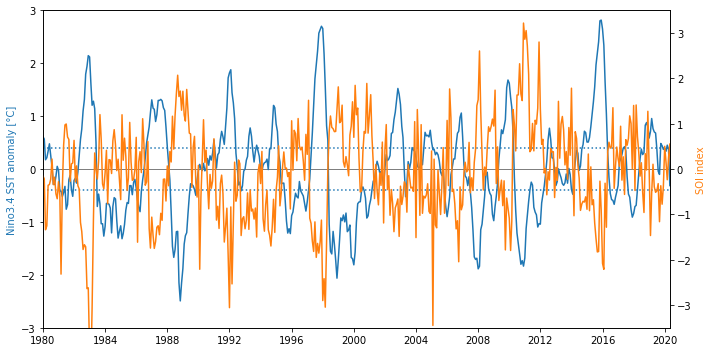

In [4]:
fignum = '06_24'

T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords').pottmp.isel(level=0).sel(lon=slice(190, 240), lat=slice(-5, 5))
climatology = T.groupby("time.month").mean("time")
anomalies = T.groupby("time.month") - climatology

P1 = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=-12, lon=131, method='nearest')
P2 = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=-18, lon=360-150, method='nearest')

fig, ax0 = plt.subplots(1, 1, figsize=(10, 5))

ax0.plot(anomalies.time, anomalies.mean('lon').mean('lat'))
ax0.hlines([0.4, -0.4], anomalies.time[0], anomalies.time[-1], colors='C00', linestyle=':')
ax0.hlines(0, anomalies.time[0], anomalies.time[-1], colors='k', linewidth=0.5, zorder=-1)
ax0.set_xlim([anomalies.time[0], anomalies.time[-1]])
ax0.set_ylim([-3, 3])
ax0.set_ylabel('Nino3.4 SST anomaly [%sC]' %degsym, color='C00')

soi = P2 - P1
climatology = soi.groupby("time.month").mean("time")
anomalies = soi.groupby("time.month") - climatology
soi = anomalies / np.std(anomalies)
ax1 = ax0.twinx()
ax1.plot(P1.time, soi, 'C01')
ax1.set_ylim([-3.5, 3.5])
ax1.set_ylabel('SOI index', color='C01')


plt.tight_layout()
savefig(fignum)

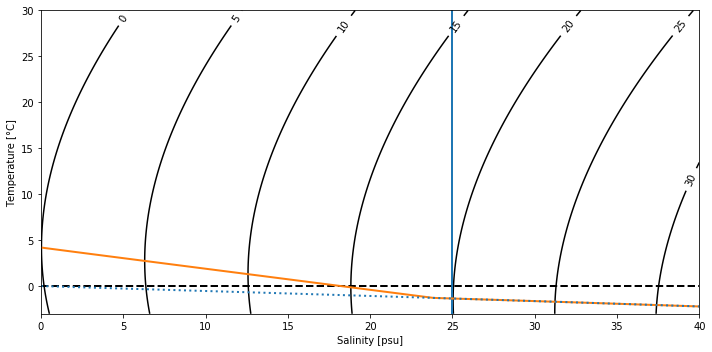

In [5]:
fignum = '07_03'

temp = np.linspace(-3, 30, 80)
salt = np.linspace(0, 40, 100)

X, Y = np.meshgrid(temp, salt)

sigma0 = gsw.density.sigma0(Y, X)

frT = gsw.CT_freezing(salt, 0, 0)
maxd = gsw.CT_maxdensity(salt, 0)
maxd = [max(i, j) for i, j in zip(frT, maxd)]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
CS = ax.contour(salt, temp, sigma0.T, np.arange(0, 31, 5), colors='k')
ax.clabel(CS, inline=1, fontsize=10, fmt='%d')
ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Temperature [%sC]' %degsym)
ax.vlines(25, -3, 30, 'C00', linewidth=2)
ax.hlines(0, 0, 40, 'k', linestyle='--', linewidth=2)
ax.plot(salt, maxd, 'C01', linewidth=2)
ax.plot(salt, frT, 'C00', linestyle=':', linewidth=2)

plt.tight_layout()
savefig(fignum)

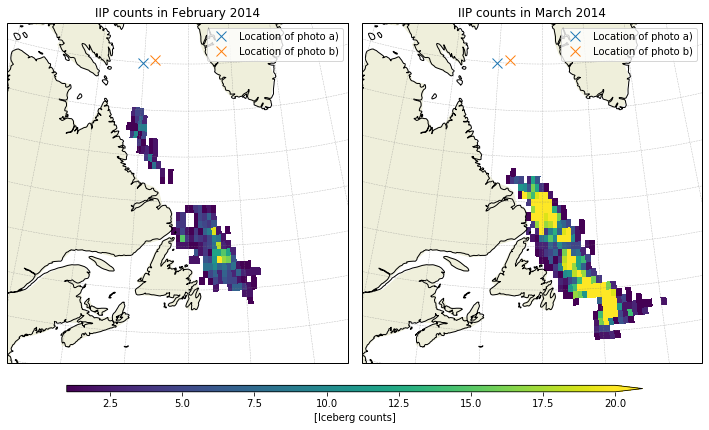

In [6]:
fignum = '07_09'

data = pd.read_csv(datadir+'OtherData/IIP/IIP_2014IcebergSeason.csv', parse_dates=True)
data['SIGHTING_DATE'] = pd.to_datetime(data['SIGHTING_DATE'], format='%m/%d/%Y')

projection = cartopy.crs.LambertConformal(central_longitude=-54)
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[7, 1])

months = [2, 3]
for i, mon in enumerate(months):
    I = np.where((data['SIGHTING_DATE'] > np.datetime64('2014-%.2d-01' %mon)) & (data['SIGHTING_DATE'] < np.datetime64('2014-%.2d-28' % mon)))[0]
    lons = data['SIGHTING_LONGITUDE'][I]
    lats = data['SIGHTING_LATITUDE'][I]
    A = np.histogram2d(lons, lats, [61, 41], range=[[-70, -40], [44, 64]])
    A[0][A[0] == 0]= np.nan

    ai = fig.add_subplot(gs[0, i], projection=projection)
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)

    a = ai.pcolormesh(A[1], A[2], A[0].T, vmin=1, vmax=20, 
                      transform=cartopy.crs.PlateCarree(), rasterized=True)
    ai.plot(-60.18, 62.97, 'x', markersize=10, label='Location of photo a)', transform=cartopy.crs.PlateCarree())
    ai.plot(-58.47, 63.20, 'x', markersize=10, label='Location of photo b)', transform=cartopy.crs.PlateCarree())
    ai.set_title('IIP counts in %s' % datetime.date(2014, mon, 1).strftime('%B %Y'))
    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')
    ai.legend()

cbaxes = fig.add_axes([0.1, 0.09, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[Iceberg counts]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

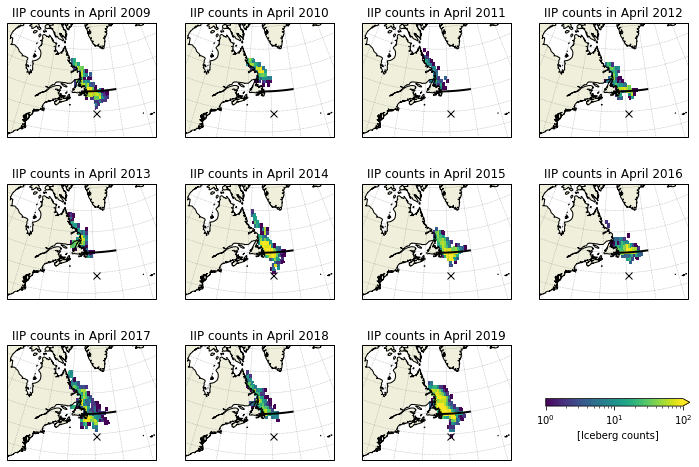

In [7]:
fignum = '07_10'

projection = cartopy.crs.LambertConformal(central_longitude=-54)
fig = plt.figure(figsize=(10, 7), constrained_layout=True)
gs = gridspec.GridSpec(3, 4)

for i, yr in enumerate(range(2009, 2020)):
    data = pd.read_csv(datadir+'OtherData/IIP/IIP_%dIcebergSeason.csv' %yr, parse_dates=True)
    datestr = 'SIGHTING\nDATE' if 'SIGHTING\nDATE' in data else 'SIGHTING_DATE'
    lonstr = 'SIGHTING\nLONGITUDE' if 'SIGHTING\nLONGITUDE' in data else 'SIGHTING_LONGITUDE'
    latstr = 'SIGHTING\nLATITUDE' if 'SIGHTING\nLATITUDE' in data else 'SIGHTING_LATITUDE'
    
    data[datestr] = pd.to_datetime(data[datestr], format='%m/%d/%Y')


    I = np.where((data[datestr] > np.datetime64('%d-04-01' %yr)) & (data[datestr] < np.datetime64('%d-04-30' % yr)))[0]
    lons = data[lonstr][I]
    lats = data[latstr][I]
    A = np.histogram2d(lons, lats, [51, 29], range=[[-80, -30], [36, 64]])

    ai = fig.add_subplot(gs[i//4, i%4], projection=projection)
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)

    a = ai.pcolormesh(A[1], A[2], A[0].T, norm=colors.LogNorm(vmin=1, vmax=100), 
                      transform=cartopy.crs.PlateCarree(), rasterized=True)
    ai.plot(-49.57, 41.44, 'kx', markersize=7, transform=cartopy.crs.PlateCarree())
    x = np.arange(-55, -40, 0.5)
    ai.plot(x, 48*np.ones(len(x)), 'k', linewidth=2, transform=cartopy.crs.PlateCarree())
    ai.set_title('IIP counts in %s' % datetime.date(yr, 4, 1).strftime('%B %Y'))
    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')

cbaxes = fig.add_axes([(0.1+3)/4, 0.5/3, 0.8/4, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[Iceberg counts]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)